# Building a Model to Predict HDB Resale Prices and Deploying it on streamlit.io

## Disclaimer

This project aims to build a model with deployment in mind. Hence, features are pre-selected based on what I would like to use in my streamlit application. However, we would still aim to build the best model based on the features we currently have.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import xgboost as xgb 
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor

from joblib import dump

pd.set_option("display.max_columns", 80)

---

## Data Cleaning

In [2]:
# loading in data
df = pd.read_csv("./datasets/train.csv")

/var/folders/mz/nzt7_nv53yb90l1j63v7r8n00000gn/T/ipykernel_10306/2795687360.py:2: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./datasets/train.csv")


In [3]:
# lowercasing column name
df.columns= df.columns.str.lower()

In [4]:
# taking first glance at data
df.head()

,id,tranc_yearmonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,tranc_year,tranc_month,mid_storey,lower,upper,mid,full_flat_type,address,floor_area_sqft,price_per_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,postal,latitude,longitude,planning_area,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km,hawker_nearest_distance,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_name,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_name,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,pri_sch_name,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,680000.0,2016,5,11,10,12,11,4 ROOM Model A,"3B, UPP BOON KENG RD",968.760,701.928238,15,25,2005,Y,N,N,N,N,142,0,0,0,96,46,0,0,0,0,0,0,0,382003,1.314299,103.872828,Kallang,1094.090418,NaN,NaN,7.0,154.753357,1.0,3.0,13.0,84,60,330.083069,Kallang,0,0,1.311540,103.871731,29.427395,Blk 3B,1.314433,103.872600,1138.633422,Geylang Methodist School,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,665000.0,2012,7,8,7,9,8,5 ROOM Improved,"153, BISHAN ST 13",1399.320,475.230826,34,9,1987,Y,N,N,N,N,112,0,0,0,56,56,0,0,0,0,0,0,0,570153,1.346086,103.855078,Bishan,866.941448,NaN,1.0,3.0,640.151925,NaN,1.0,7.0,80,77,903.659703,Bishan,1,1,1.350580,103.848305,58.207761,BLK 151A MKT,1.345659,103.855381,415.607357,Kuo Chuan Presbyterian Primary School,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892
2,170897,2013-07,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997,838000.0,2013,7,14,13,15,14,EXECUTIVE Apartment,"289B, BT BATOK ST 25",1550.016,540.639580,24,16,1996,Y,N,N,N,N,90,0,0,0,0,30,60,0,0,0,0,0,0,651289,1.343867,103.760535,Bukit Batok,1459.579948,NaN,NaN,4.0,1762.082341,NaN,NaN,1.0,84,95,1334.251197,Bukit Batok,1,0,1.349561,103.749970,214.747860,Blk 289E,1.344064,103.758613,498.849039,Keming Primary School,39,0,1.345245,103.756265,180.074558,Yusof Ishak Secondary School,188,0,1.342334,103.760013
3,86070,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992,550000.0,2012,4,3,1,5,3,4 ROOM Model A,"232, BISHAN ST 22",1108.692,496.080066,29,11,1990,Y,Y,N,N,N,75,0,0,0,68,7,0,0,0,0,0,0,0,570232,1.358245,103.845504,Bishan,950.175199,NaN,1.0,4.0,726.215262,NaN,1.0,9.0,32,86,907.453484,Bishan,1,1,1.350580,103.848305,43.396521,Opp Bishan Nth Shop Mall,1.358045,103.845169,389.515528,Catholic High School,20,1,1.354789,103.844934,389.515528,Catholic High School,253,1,1.354789,103.844934
4,153632,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987,298000.0,2017,12,2,1,3,2,4 ROOM Simplified,"876, YISHUN ST 81",893.412,333.552717,34,4,1987,Y,N,N,N,N,48,0,0,0,30,18,0,0,0,0,0,0,0,760876,1.414745,103.835532,Yishun,729.771895,NaN,1.0,2.0,1540.151439,NaN,NaN,1.0,45,0,412.343032,Khatib,0,0,1.417131,103.832692,129.422752,Blk 873,1.415424,103.836477,401.200584,Naval Base Primary School,74,0,1.416280,103.838798,312.025435,Orchid Park Secondary School,208,0,1.414888,103.838335


In [5]:
# final selection of features I would like to include in my final model
df = df[['flat_type','floor_area_sqft','lease_commence_date','mid','planning_area','resale_price']]

In [6]:
# checking for null values
df.isna().sum()

flat_type              0
floor_area_sqft        0
lease_commence_date    0
mid                    0
planning_area          0
resale_price           0
dtype: int64

In [7]:
# checking the dtypes
dtypes = pd.DataFrame(df.dtypes,columns=['dtype'])
dtypes.sort_values(by='dtype')

,dtype
lease_commence_date,int64
mid,int64
floor_area_sqft,float64
resale_price,float64
flat_type,object
planning_area,object


---

## Exploratory Data Analysis

### Numerical Features

#### Heatmap of Numerical Features

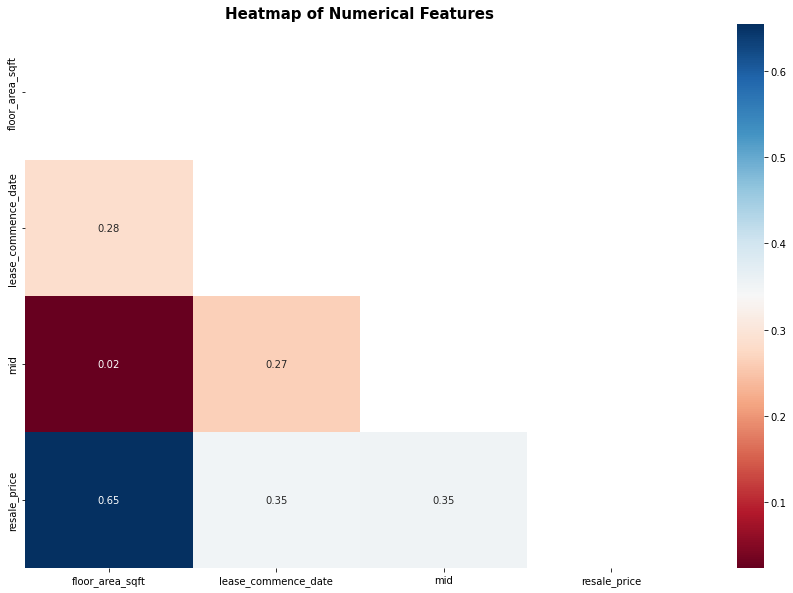

In [8]:
plt.figure(figsize=(15,10))
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, fmt= '.2f', cmap='RdBu', mask=mask)
plt.title('Heatmap of Numerical Features',fontsize=15,fontweight='bold')
plt.show()

#### Scatterplot of Numerical Features

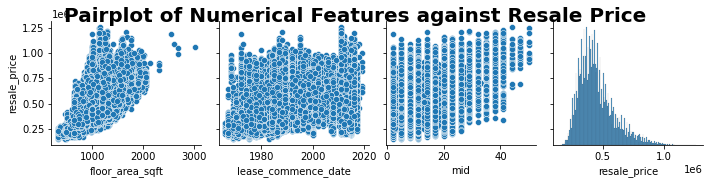

In [9]:
# exploring relationship between numerical features
pp = sns.pairplot(data=df,y_vars=['resale_price'])
pp.fig.suptitle("Pairplot of Numerical Features against Resale Price", fontsize=20, fontweight='bold');

#### Distributions of Numerical Features

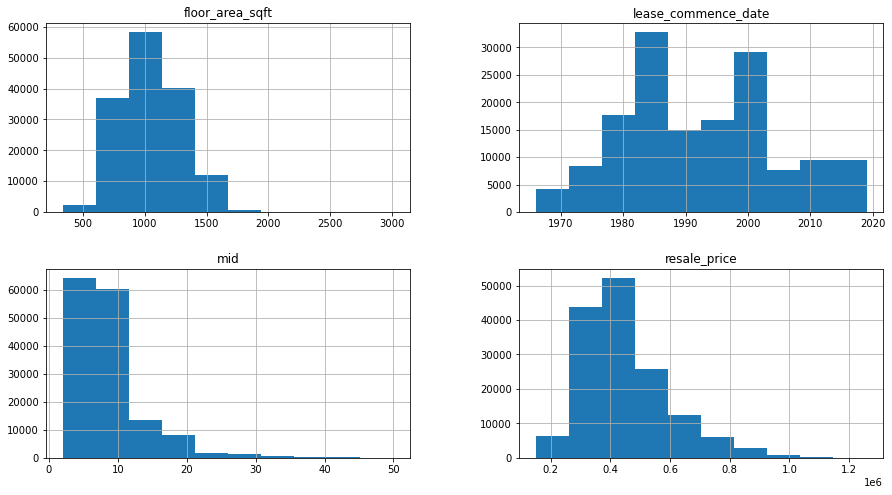

In [10]:
df.hist(figsize=(15,8));

### Categorical Features

In [11]:
def plot_boxplot(df,variable_name,title_name,plot_order):
    plt.figure(figsize=(15,5))
    sns.boxplot(data=df, x=variable_name,y='resale_price',order=plot_order)
    plt.title(f'Boxplot of {title_name.title()} against Resale Price', fontsize=15, fontweight='bold');

#### Flat Type

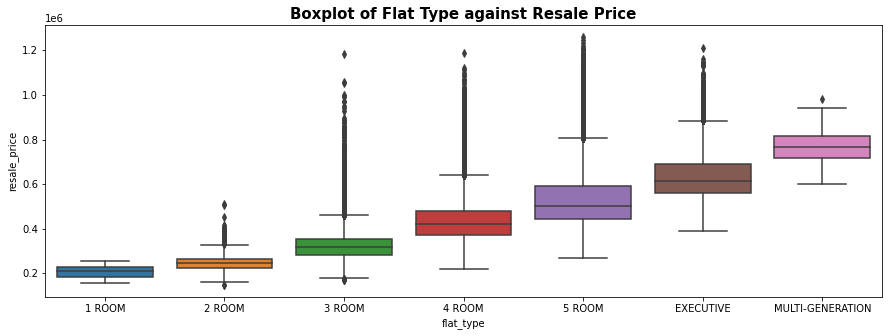

In [12]:
plot_boxplot(df,'flat_type','flat type',['1 ROOM','2 ROOM','3 ROOM','4 ROOM','5 ROOM','EXECUTIVE','MULTI-GENERATION'])

In [13]:
df['planning_area'].loc[(df['flat_type']=='5 ROOM') & (df['resale_price'] > 800000)].value_counts()

Bukit Merah      522
Toa Payoh        368
Queenstown       367
Kallang          203
Bishan           179
Ang Mo Kio       150
Outram           130
Marine Parade    119
Geylang          106
Clementi          91
Bedok             39
Bukit Timah       39
Tampines          23
Tanglin           13
Punggol           10
Hougang            7
Serangoon          1
Rochor             1
Pasir Ris          1
Name: planning_area, dtype: int64

Discovered that the outliers are in better planning areas

#### Region

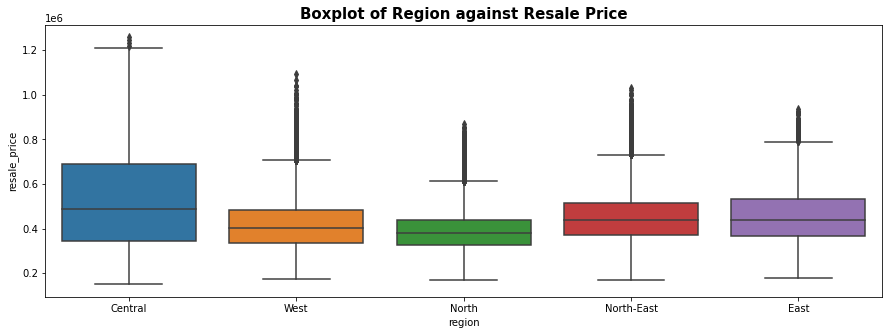

In [14]:
# scrape data from wikipedia so that I can create a region column
url = 'https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
table = soup.find_all('table')[2]
# creating a region dataframe
region_table = pd.read_html(str(table))[0]
region_table = region_table[['Name (English)','Region']]
# converting dataframe to dictionary
dictionary = region_table.set_index('Name (English)')['Region'].to_dict()

# mapping area to region
df['region'] = df['planning_area'].map(dictionary)

# identify lower quartile of central and group them to central & non central
plot_boxplot(df,'region','region',None)

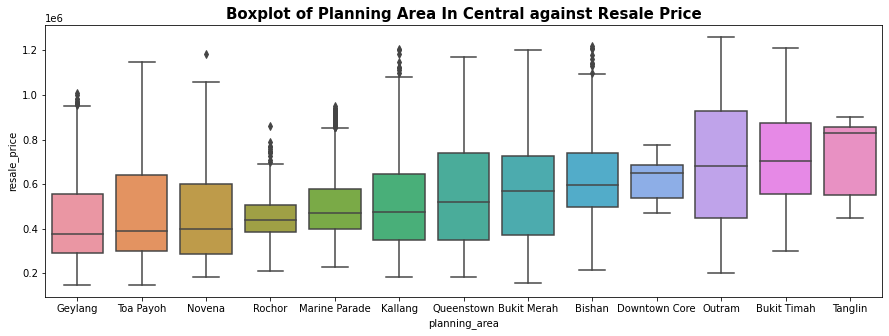

In [15]:
# create df of only planning area and resale price
temp_df = df[['planning_area','resale_price']].loc[df['region'] == 'Central'].sort_values(by='resale_price')
# group categorical values by median
grouped = temp_df.loc[:,['planning_area', 'resale_price']] \
    .groupby(['planning_area']) \
    .median() \
    .sort_values(by='resale_price')
plot_boxplot(temp_df,'planning_area','planning area in central',grouped.index)

In [16]:
# drop region column as it is not really useful
df.drop(columns='region',inplace=True)

In [17]:
# saving final df to csv
df.to_csv('./datasets/final_csv',index=False)

---

## Preprocessing & Modelling

In [18]:
# independent variables
X = df.drop(columns='resale_price')
# dependent variables
y = df['resale_price']

### Train-Test Split

In [19]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Preprocessing with ColumnTransformer

In [20]:
# ColumnTransformer for preprocessing
ct = ColumnTransformer([('powertransformer',PowerTransformer(),[1,2,3]),
                        ('ohe',OneHotEncoder(),[0,4])])

### RMSE Function

In [21]:
def get_rmse(model,x, y):
    y_pred = model.predict(x)
    rmse = mean_squared_error(y,y_pred,squared=False)
    return rmse

### Baseline Model

In [22]:
# pipeline for model training
baseline_model = Pipeline(steps=[('columntransformer',ct),
                      ('linearregression',LinearRegression())])
baseline_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('powertransformer',
                                                  PowerTransformer(),
                                                  [1, 2, 3]),
                                                 ('ohe', OneHotEncoder(),
                                                  [0, 4])])),
                ('linearregression', LinearRegression())])

#### Baseline Model RMSE

In [23]:
print("Model Train RMSE: %.3f" % get_rmse(baseline_model, X_train, y_train))
print("Model Test RMSE: %.3f" % get_rmse(baseline_model, X_test, y_test))

Model Train RMSE: 73474.332
Model Test RMSE: 73422.395


### Finding the best model & Hyperparameter Tuning

In [24]:
class ClfSwitcher(BaseEstimator):

    def __init__(
        self, 
        estimator = LinearRegression(),
    ):
        """
        A Custom BaseEstimator that can switch between regressors.
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

In [25]:
# pipeline = Pipeline([
#     ('ColumnTransformer', ct),
#     ('clf', TransformedTargetRegressor(regressor=ClfSwitcher(),
#                                        func=np.log,
#                                        inverse_func=np.exp))
# ])

# parameters = [
#     {
#         'clf__regressor__estimator': [LinearRegression()] 
#     },
#     {
#         'clf__regressor__estimator': [xgb.XGBRegressor()],
#         'clf__regressor__estimator__learning_rate': [0.1, 0.3, 0.5, 0.7],
#         'clf__regressor__estimator__max_depth': [3, 5, 7, 9]
    
#     },
#     {
#         'clf__regressor__estimator': [KNeighborsRegressor()],
#         'clf__regressor__estimator__n_neighbors': [3, 5, 7, 9, 11],  # number of neighbors to consider
#         'clf__regressor__estimator__weights': ['uniform', 'distance']
    
#     },
#     {
#         'clf__regressor__estimator': [RandomForestRegressor()],
#         'clf__regressor__estimator__n_estimators': [100, 200, 300],  # number of trees in the forest
#         'clf__regressor__estimator__max_depth': [5, 10, 20]
    
#     }]

# gscv = GridSearchCV(pipeline, parameters, cv=5, n_jobs=12, return_train_score=False, verbose=3)
# gscv.fit(X_train, y_train)

In [26]:
#gscv.best_estimator_

Best model is the XGBRegressor

In [27]:
#get_rmse(gscv, X_train, y_train)

Train RMSE : 36677

In [28]:
#get_rmse(gscv, X_test, y_test)

Test RMSE: 39574

There is generally low overfitting

In [29]:
#gscv.best_params_

XGBRegressor Best Params: learning_rate=0.3, max_depth=9

### VotingRegressor

#### Models

In [30]:
xgboost_model = xgb.XGBRegressor(learning_rate=0.3, max_depth=9)
# randomforest_model = RandomForestRegressor(max_depth=20,n_estimators=300)
# knn_model = KNeighborsRegressor(n_neighbors=11, weights='distance')

#### VotingRegressor Pipeline

In [31]:
# votingregressor_pipeline = Pipeline(steps=[('ColumnTransformer', ct),
#                                           ('VotingRegressor', VotingRegressor([('xgboost',xgboost_model),
#                                                                                ('randomforest', randomforest_model),
#                                                                                ('knn', knn_model)],
#                                                                               weights=[2,1,1]))])
# votingregressor_pipeline.fit(X_train, y_train)

In [32]:
#get_rmse(votingregressor_pipeline, X_train, y_train)

Train RMSE: 39280

In [33]:
#get_rmse(votingregressor_pipeline, X_test, y_test)

Test RMSE: 42737

VotingRegressor takes too long to make prediction and is worse than just using XGBoost Model

### Building the Final Pipeline

In [34]:
final_model = Pipeline(steps=[('ColumnTransformer', ct),
                      ('XGBRegressor', xgboost_model)])

final_model.fit(X_train, y_train)

print(f'Train RMSE: {get_rmse(final_model, X_train, y_train)}')
print(f'Test RMSE: {get_rmse(final_model, X_test, y_test)}')

Train RMSE: 36432.10720022915
Test RMSE: 39463.75010336925


Final model makes prediction really quickly and does better than using VotingRegressor. Also, TransformedTargetRegressor is not used as not using it improved RMSE by a little.

## Predict for submission on Kaggle

In [35]:
kaggle_test = pd.read_csv('./datasets/test.csv')

/var/folders/mz/nzt7_nv53yb90l1j63v7r8n00000gn/T/ipykernel_10306/3372247938.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  kaggle_test = pd.read_csv('./datasets/test.csv')


In [36]:
test_pred = final_model.predict(kaggle_test)

In [37]:
kaggle_test['pred'] = test_pred

In [38]:
kaggle_test = kaggle_test[['id','pred']]

In [39]:
kaggle_test.to_csv('./datasets/kaggle_test.csv')

Model scored ~39000 on Kaggle signifying no overfitting

## Export Model for Deployment

In [40]:
dump(final_model, 'final_model.joblib')

['final_model.joblib']